In [19]:
import geopandas as gpd
import pandas as pd
from siuba import *

from shared_utils import rt_dates, rt_utils, geography_utils
from segment_speed_utils import helpers
from segment_speed_utils.project_vars import SEGMENT_GCS, PROJECT_CRS

from prep_comparison import map_one_trip, remove_interpolated_segments

analysis_date = rt_dates.DATES["sep2023"]

import folium
import numpy as np

In [2]:
from calitp_data_analysis.calitp_color_palette import CALITP_CATEGORY_BOLD_COLORS

In [3]:
df_eric = gpd.read_parquet(f"{SEGMENT_GCS}speeds_eric_{analysis_date}.parquet")
df_eric = remove_interpolated_segments(df_eric)
df_tiff = gpd.read_parquet(f"{SEGMENT_GCS}speeds_tiff_{analysis_date}.parquet")
df_tiff_interp = pd.read_parquet(f"{SEGMENT_GCS}speeds_tiff_interp_{analysis_date}.parquet")
speed_df = pd.read_parquet(
    f"{SEGMENT_GCS}speeds_comparison_{analysis_date}.parquet")

# Dataset-level comparison


In [5]:
speed_df >> count(_._merge)

,_merge,n
0,left_only,8067
1,right_only,0
2,both,130920


In [20]:
#  some infinite speeds present
speed_df = speed_df >> filter(_._merge == 'both', _.tiff_interp_speed_mph < np.inf)

In [21]:
speed_df['interp_difference'] = speed_df.tiff_interp_speed_mph - speed_df.eric_speed_mph

/tmp/ipykernel_319/1626851892.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speed_df['interp_difference'] = speed_df.tiff_interp_speed_mph - speed_df.eric_speed_mph


In [22]:
speed_df >> filter(_.tiff_interp_speed_mph > 80)

,trip_id,shape_id,stop_id,stop_sequence,route_id,direction_id,eric_speed_mph,tiff_speed_mph,_merge,tiff_interp_speed_mph,interp_difference
891,10040009470701-JUNE23,400947_JUNE23,683,3.0,40-13168,1.0,7.236980,7.286552,both,99.146632,91.909652
893,10040009470808-JUNE23,400947_JUNE23,683,3.0,40-13168,1.0,3.888103,8.222882,both,90.133302,86.245199
895,10040009470535-JUNE23,400947_JUNE23,683,3.0,40-13168,1.0,1.436908,4.609504,both,82.622193,81.185286
898,10040009470758-JUNE23,400947_JUNE23,683,3.0,40-13168,1.0,7.931731,8.454223,both,123.933290,116.001560
1502,10222000790716-JUNE23,2220079_JUNE23,13038,3.0,222-13168,1.0,52.233934,28.658222,both,348.226230,295.992295
...,...,...,...,...,...,...,...,...,...,...,...
124525,10460002000705-JUNE23,4600200_JUNE23,16926,69.0,460-13168,0.0,23.951370,25.758521,both,191.610963,167.659593
124531,10106000690704-JUNE23,1060069_JUNE23,4427,69.0,106-13168,0.0,12.680597,3.190622,both,97.217912,84.537315
124534,10106000690744-JUNE23,1060069_JUNE23,4427,69.0,106-13168,0.0,14.582687,5.579753,both,124.994459,110.411772
125477,10070003020649-JUNE23,700302_JUNE23,2176,70.0,70-13168,0.0,9.890274,17.969755,both,890.124693,880.234419


<AxesSubplot:>

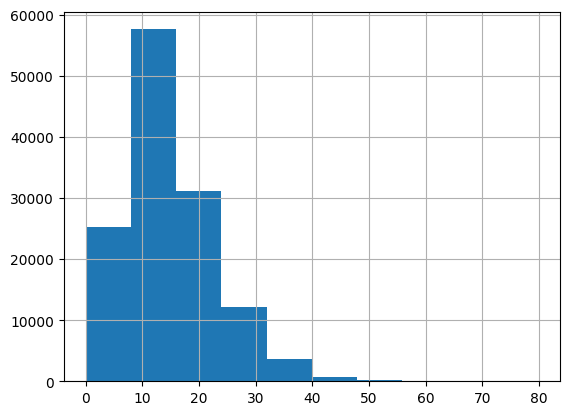

In [9]:
speed_df.eric_speed_mph.hist()

In [44]:
# (speed_df >> filter(_.tiff_speed_mph < 80)).tiff_speed_mph.hist()

<AxesSubplot:>

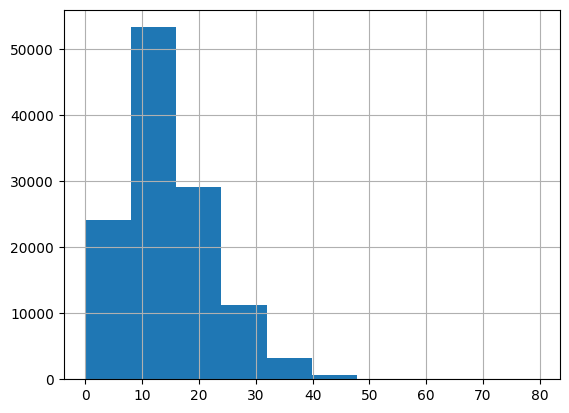

In [11]:
(speed_df >> filter(_.tiff_interp_speed_mph < 80)).tiff_interp_speed_mph.hist()

In [23]:
speed_df.describe()

,stop_sequence,direction_id,eric_speed_mph,tiff_speed_mph,tiff_interp_speed_mph,interp_difference
count,121737.000000,121737.000000,121737.000000,121737.000000,121737.000000,121737.000000
mean,36.838644,0.513016,14.809543,12.060441,14.905457,0.095914
std,23.039439,0.499833,7.888698,12.575817,13.582043,11.456724
min,3.000000,0.000000,0.056044,0.000000,0.119131,-77.173946
25%,18.000000,0.000000,8.956067,6.351169,8.917777,-0.301087
50%,34.000000,1.000000,13.242002,9.825973,13.205725,0.000000
75%,53.000000,1.000000,19.108548,15.253100,19.027581,0.000000
max,133.000000,1.000000,79.688768,2442.099225,1559.351151,1544.777775


In [24]:
speed_df.interp_difference.quantile(.95)

1.8884715484353258

In [25]:
speed_df.interp_difference.quantile(.05)

-1.8717697511490712

## Differences by route at 80th, 90th percentiles

* limited opportunity for further investigation, but again generally very good!

In [30]:
p80_diffs = speed_df >> group_by(_.route_id, _.shape_id) >> summarize(p80_difference = _.interp_difference.quantile(.8))

In [31]:
p80_diffs >> arrange(-_.p80_difference)

,route_id,shape_id,p80_difference
280,51-13168,510344_JUNE23,14.594673
348,805,805WB_190513,9.230499
341,802,802EB_190513,6.481253
344,803,803WB_120215,6.030507
342,802,802WB_190513,5.432001
...,...,...,...
367,92-13168,920299_JUNE23,0.000000
368,94-13168,940256_JUNE23,0.000000
369,94-13168,940258_JUNE23,0.000000
370,96-13168,960250_JUNE23,0.000000


In [39]:
p80_diffs >> count(_.p80_difference)

,p80_difference,n
0,0.000000,355
1,0.119273,1
2,0.244066,1
3,0.361835,1
4,0.417922,1
5,0.451117,1
6,0.719416,1
7,0.780447,1
8,0.821906,1
9,1.050404,1


In [34]:
p90_diffs = speed_df >> group_by(_.route_id, _.shape_id) >> summarize(p90_difference = _.interp_difference.quantile(.9))

In [35]:
(p90_diffs >> arrange(-_.p90_difference))

,route_id,shape_id,p90_difference
280,51-13168,510344_JUNE23,17.608822
348,805,805WB_190513,11.145241
342,802,802WB_190513,11.103630
341,802,802EB_190513,10.504373
291,577-13168,5770040_JUNE23,9.318308
...,...,...,...
367,92-13168,920299_JUNE23,0.000000
368,94-13168,940256_JUNE23,0.000000
369,94-13168,940258_JUNE23,0.000000
370,96-13168,960250_JUNE23,0.000000


In [42]:
rt_utils.show_full_df((p90_diffs >> arrange(-_.p90_difference)) >> filter(_.p90_difference > 0))

,route_id,shape_id,p90_difference
280,51-13168,510344_JUNE23,17.608822
348,805,805WB_190513,11.145241
342,802,802WB_190513,11.103630
341,802,802EB_190513,10.504373
291,577-13168,5770040_JUNE23,9.318308
284,53-13168,530240_JUNE23,7.956904
344,803,803WB_120215,7.737499
273,51-13168,510324_JUNE23,7.678630
339,801,801NB_RC_221121,5.241358
346,804,804WB_RC_221121,3.389427


In [37]:
p90_diffs >> count(_.p90_difference)

,p90_difference,n
0,0.000000,274
1,0.002339,1
2,0.010921,1
3,0.028280,1
4,0.028583,1
...,...,...
94,9.318308,1
95,10.504373,1
96,11.103630,1
97,11.145241,1


# Conclusion

* `rt_delay` and post-interpolation `rt_segment_speeds` results are now substantially in alignment
* Accuracy is no longer a blocker to publishing/promoting this data
* Speedmaps could be transitioned with a few more steps, for example by
    * porting the "virtual segments" approach for long stop spacings into a version of `rt_segment_speeds`
    * deprecating `rt_analysis.rt_parser`
    * reworking `rt_analysis.rt_filter_map_plot` and associated `RtFilterMapper` class to provide an interface to `rt_segment speeds`
* Routes highlighted above could be investigated further to understand remaining discrepancies 